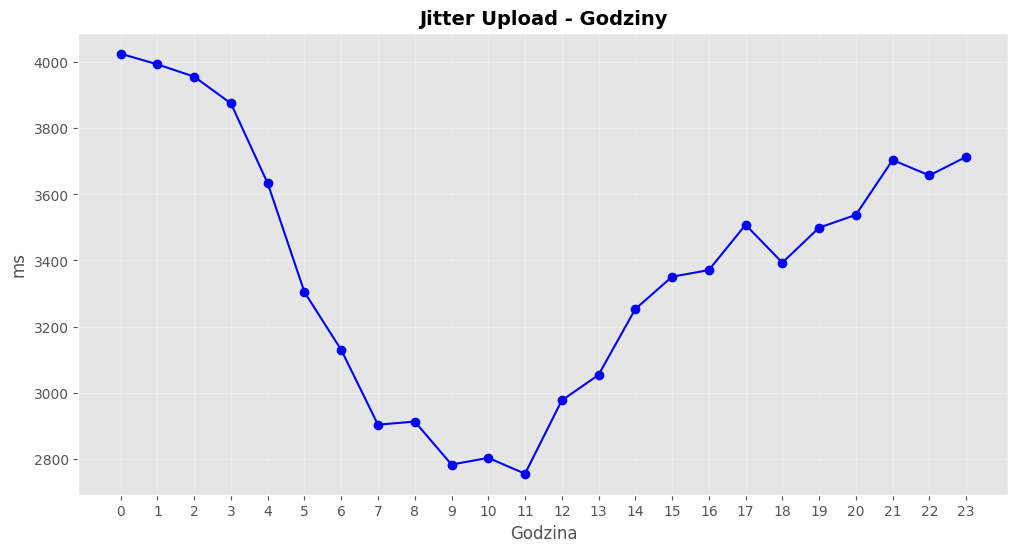

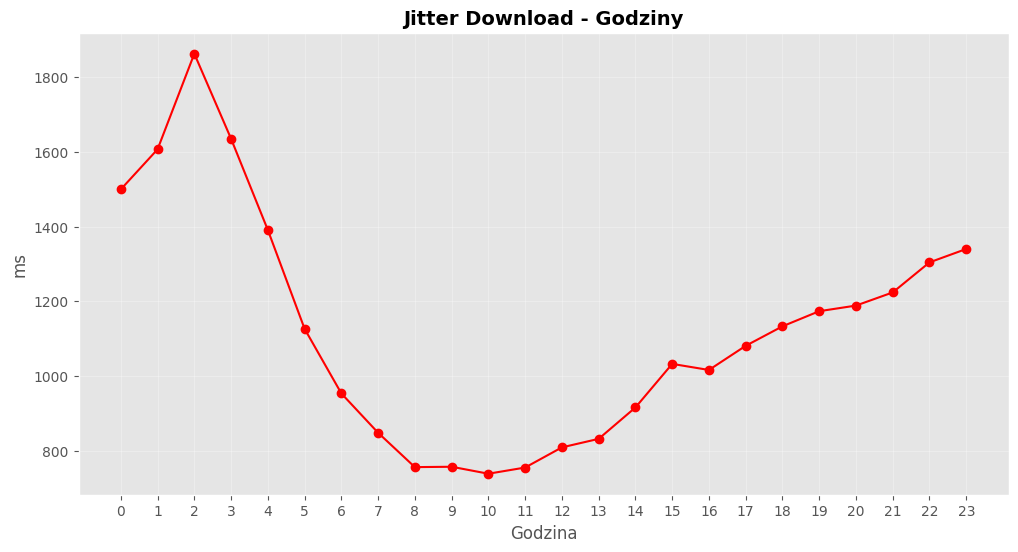

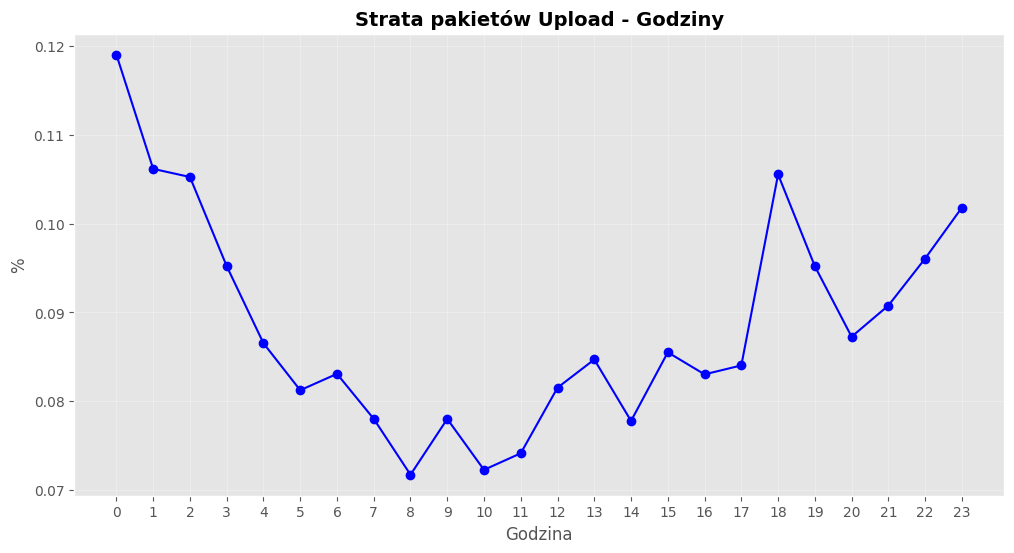

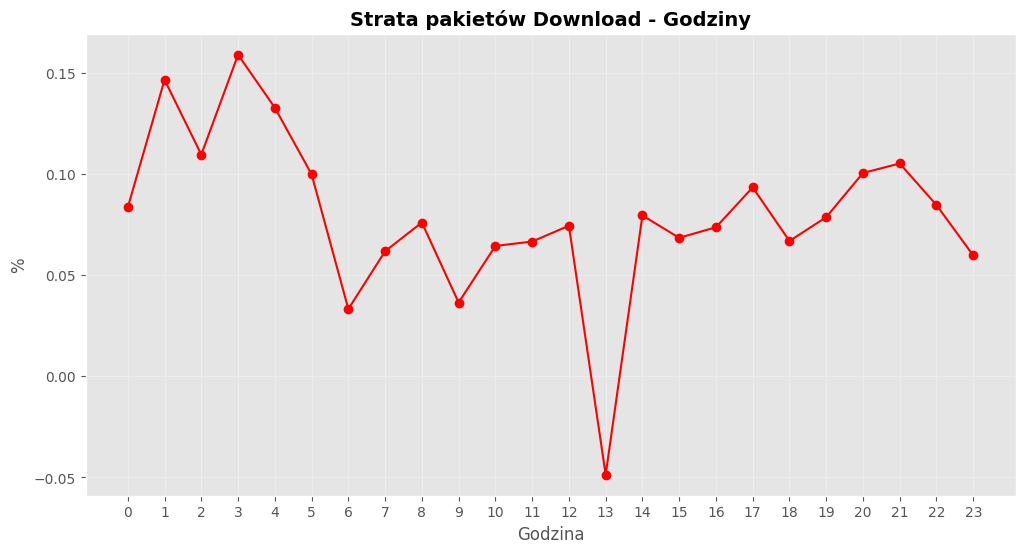

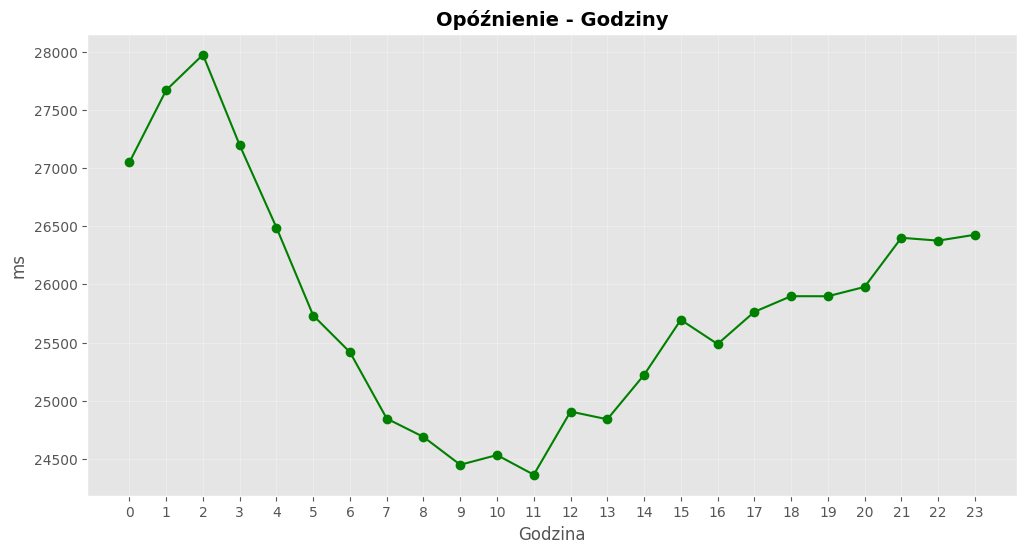

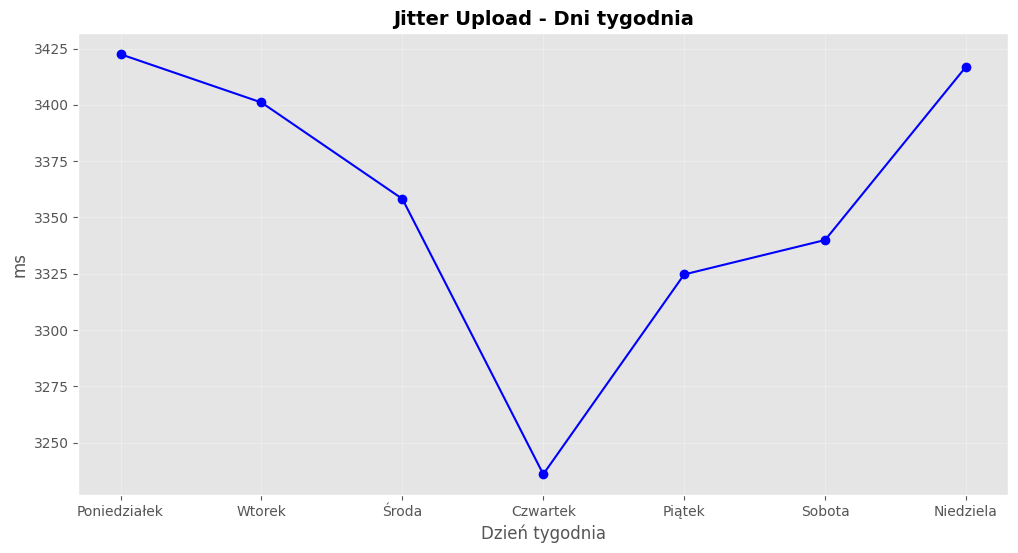

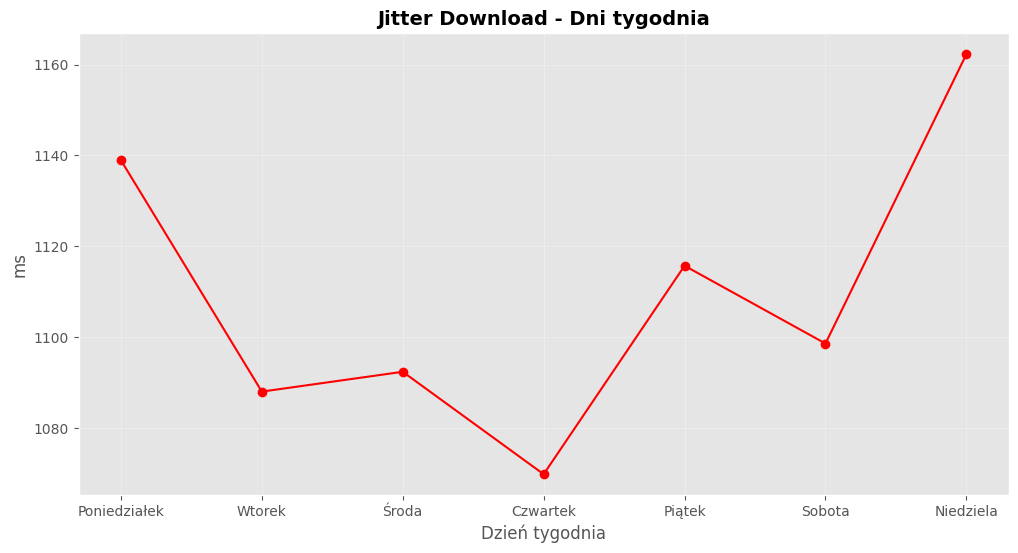

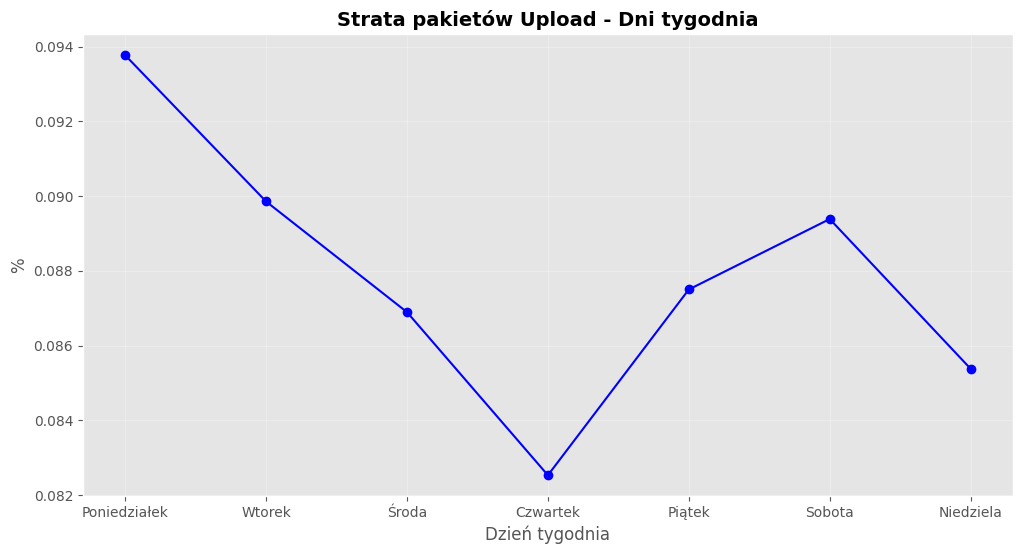

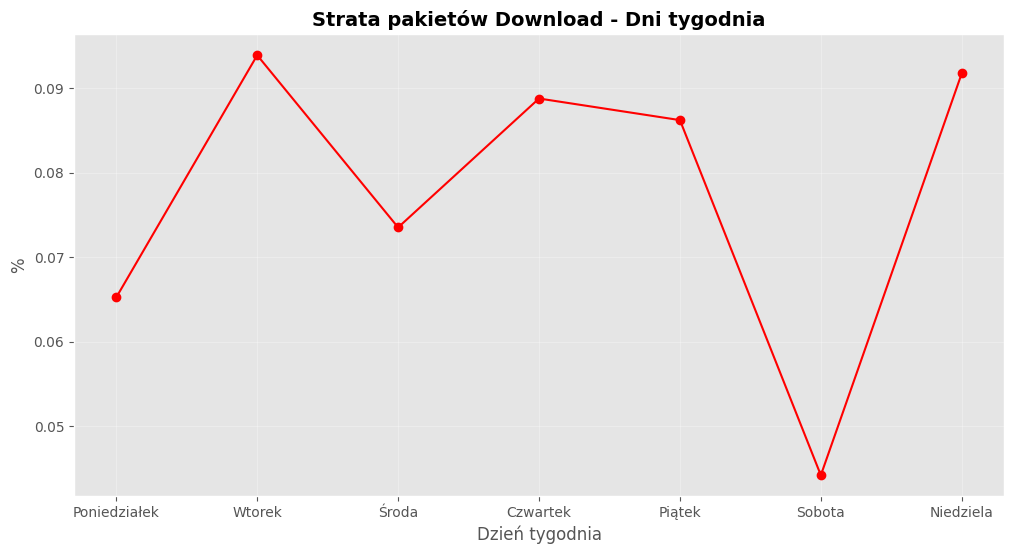

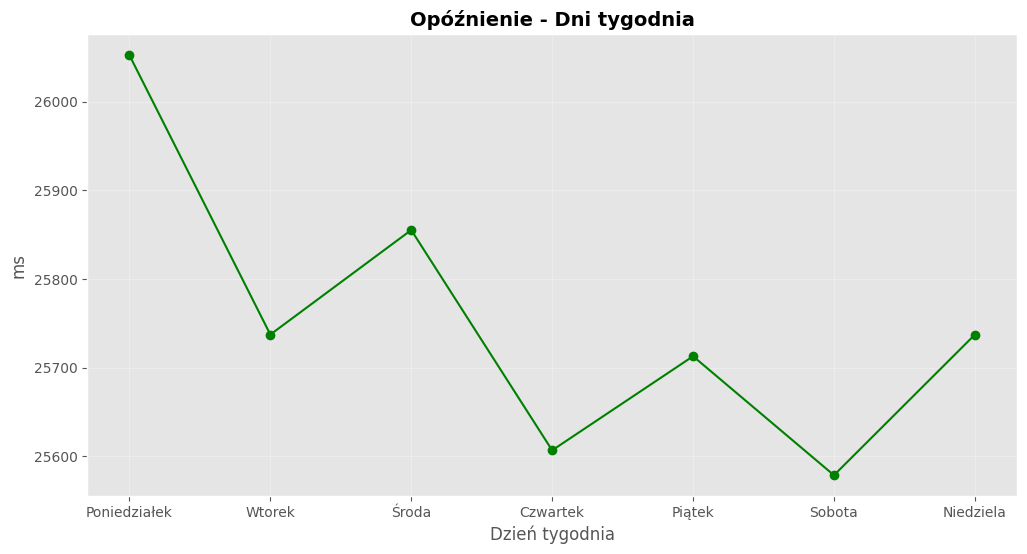

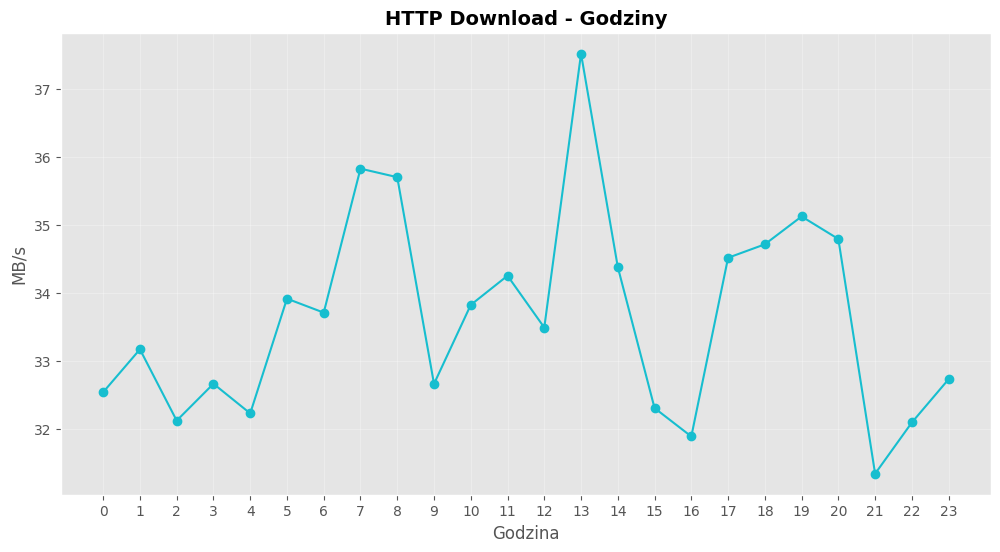

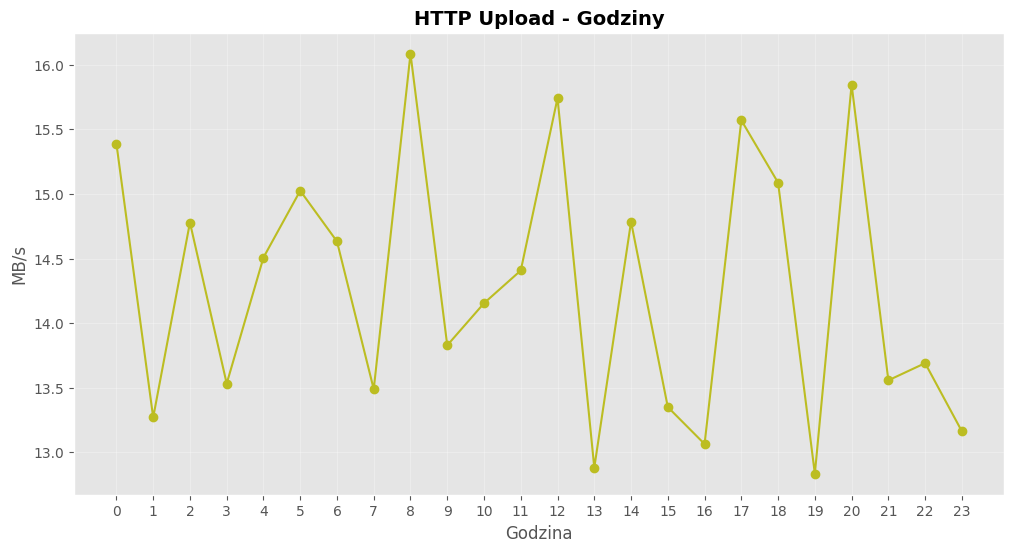

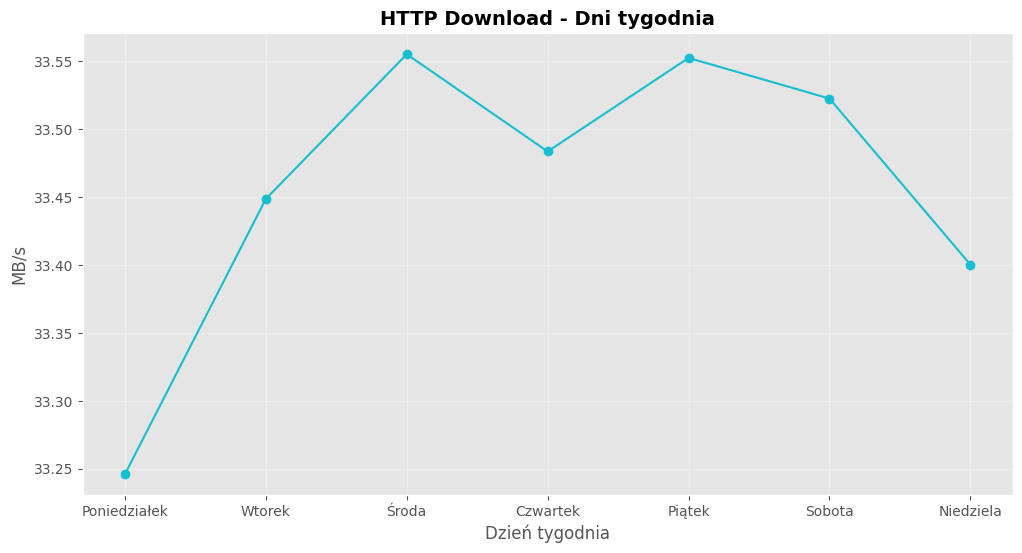

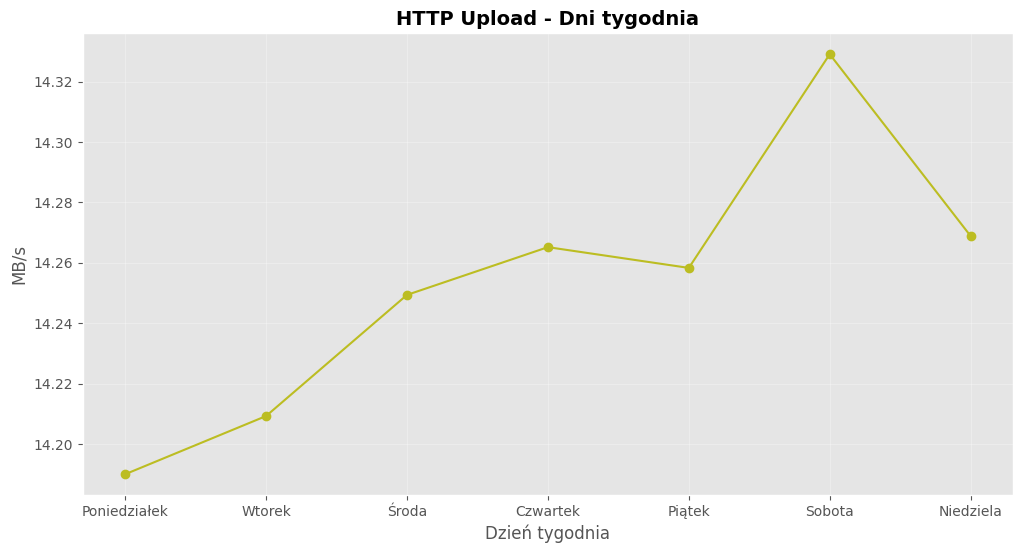

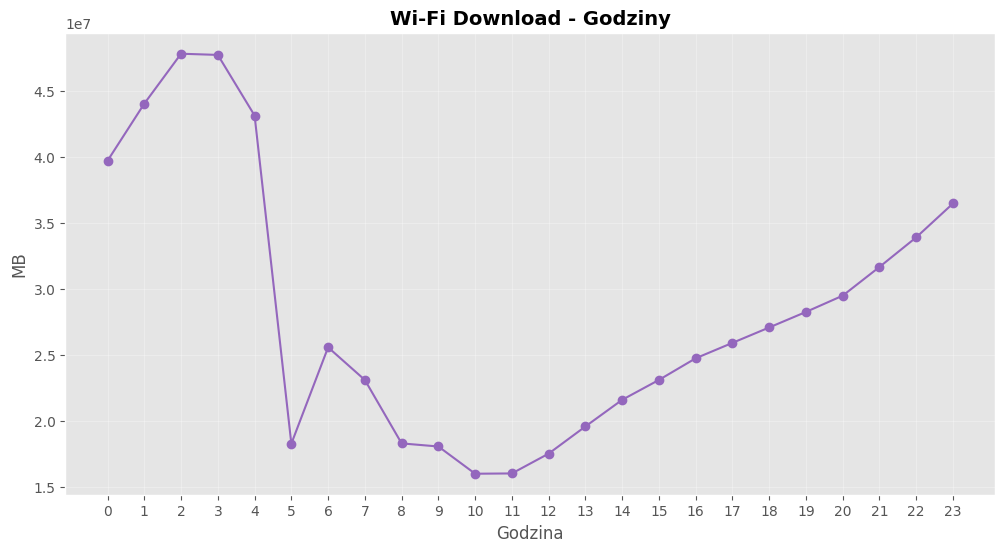

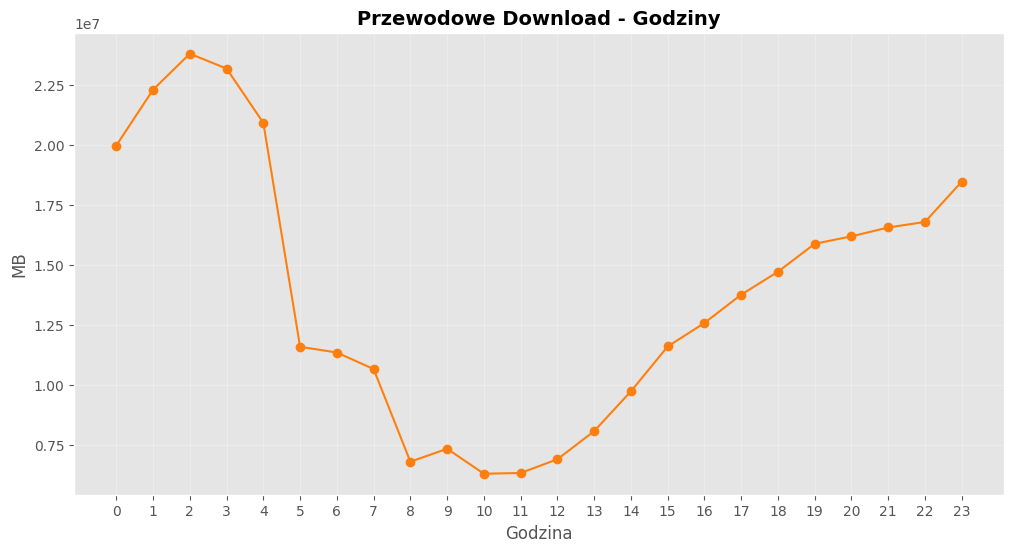

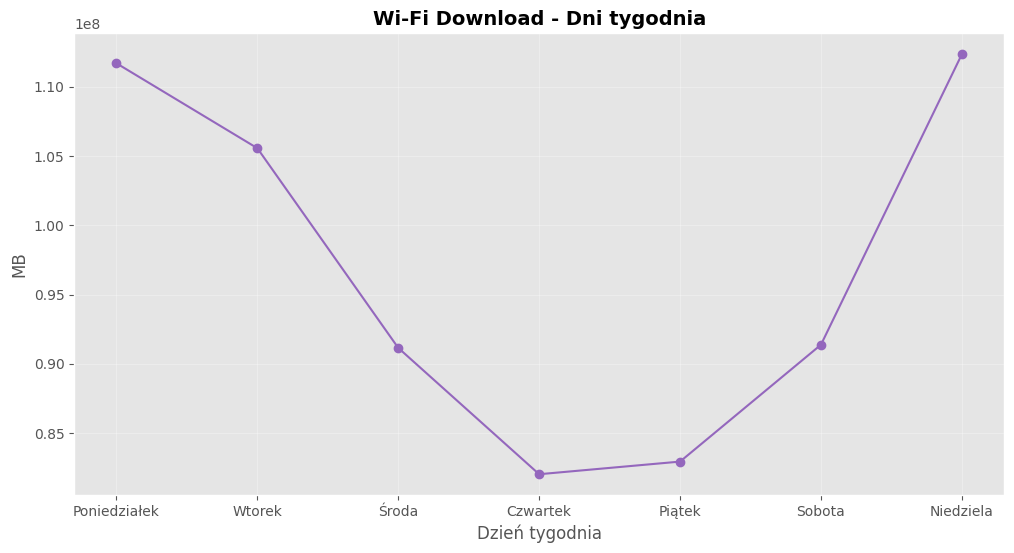

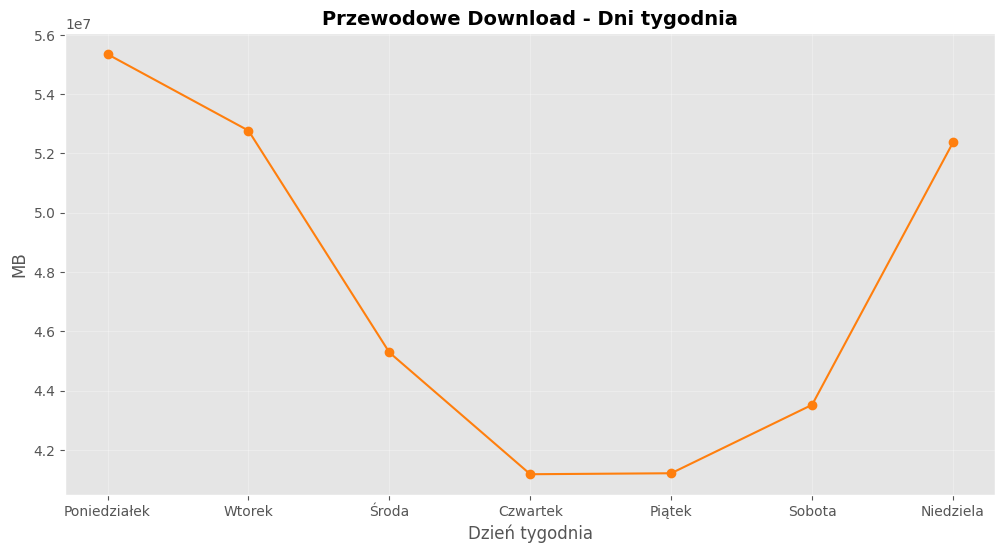

In [4]:
# -*- coding: utf-8 -*-
# Część 1: Importy i konfiguracja
import pandas as pd
import matplotlib.pyplot as plt

# Konfiguracja stylu
plt.style.use('ggplot')
COLORS = {
    'upload': '#1f77b4',
    'download': '#d62728',
    'latency': '#2ca02c',
    'wifi': '#9467bd',
    'wired': '#ff7f0e',
    'http_get': '#17becf',
    'http_post': '#bcbd22'
}
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'grid.alpha': 0.3
})

# --------------------------------------------------
# Część 2: Wspólne funkcje pomocnicze
# --------------------------------------------------
def add_time_columns(df):
    df['hour'] = df['dtime'].dt.hour
    df['day_of_week'] = df['dtime'].dt.dayofweek.map({
        0: 'Poniedziałek', 1: 'Wtorek', 2: 'Środa',
        3: 'Czwartek', 4: 'Piątek', 5: 'Sobota', 6: 'Niedziela'
    })
    return df

# --------------------------------------------------
# Część 3: Analiza UDP - Przygotowanie danych
# --------------------------------------------------
udp_df = pd.read_csv('data/curr_udpjitter_clean.csv', parse_dates=['dtime'])
udp_df = add_time_columns(udp_df)
udp_df['packet_loss_up'] = (udp_df['packets_up_sent'] - udp_df['packets_up_recv']) / udp_df['packets_up_sent'] * 100
udp_df['packet_loss_down'] = (udp_df['packets_down_sent'] - udp_df['packets_down_recv']) / udp_df['packets_down_sent'] * 100

udp_hourly = udp_df.groupby('hour').mean(numeric_only=True).reset_index()
udp_daily = udp_df.groupby('day_of_week').mean(numeric_only=True).reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

# --------------------------------------------------
# Część 4: Wykresy UDP - Godzinowe
# --------------------------------------------------
# Wykres 1: Jitter Upload godzinowy
plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['jitter_up'], 'b-o')
plt.title('Jitter Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 2: Jitter Download godzinowy
plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['jitter_down'], 'r-o')
plt.title('Jitter Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 3: Strata pakietów Upload godzinowa
plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_up'], 'b-o')
plt.title('Strata pakietów Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 4: Strata pakietów Download godzinowa
plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_down'], 'r-o')
plt.title('Strata pakietów Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 5: Opóźnienie godzinowe
plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['latency'], 'g-o')
plt.title('Opóźnienie - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# --------------------------------------------------
# Część 5: Wykresy UDP - Dni tygodnia
# --------------------------------------------------
# Wykres 6: Jitter Upload dzienny
plt.figure()
plt.plot(udp_daily['day_of_week'], udp_daily['jitter_up'], 'b-o')
plt.title('Jitter Upload - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('ms')
plt.grid(True)
plt.show()

# Wykres 7: Jitter Download dzienny
plt.figure()
plt.plot(udp_daily['day_of_week'], udp_daily['jitter_down'], 'r-o')
plt.title('Jitter Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('ms')
plt.grid(True)
plt.show()

# Wykres 8: Strata pakietów Upload dzienna
plt.figure()
plt.plot(udp_daily['day_of_week'], udp_daily['packet_loss_up'], 'b-o')
plt.title('Strata pakietów Upload - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('%')
plt.grid(True)
plt.show()

# Wykres 9: Strata pakietów Download dzienna
plt.figure()
plt.plot(udp_daily['day_of_week'], udp_daily['packet_loss_down'], 'r-o')
plt.title('Strata pakietów Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('%')
plt.grid(True)
plt.show()

# Wykres 10: Opóźnienie dzienne
plt.figure()
plt.plot(udp_daily['day_of_week'], udp_daily['latency'], 'g-o')
plt.title('Opóźnienie - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('ms')
plt.grid(True)
plt.show()

# --------------------------------------------------
# Część 6: Analiza HTTP - Przygotowanie danych
# --------------------------------------------------
httpget = pd.read_csv("data/curr_httpgetmt_clean.csv", parse_dates=["dtime"])
httppost = pd.read_csv("data/curr_httppostmt_clean.csv", parse_dates=["dtime"])

httpget = add_time_columns(httpget)
httppost = add_time_columns(httppost)

httpget['MB/s'] = httpget['bytes_sec'] / 1e6
httppost['MB/s'] = httppost['bytes_sec'] / 1e6

httpget_hourly = httpget.groupby('hour')['MB/s'].mean().reset_index()
httpget_daily = httpget.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

httppost_hourly = httppost.groupby('hour')['MB/s'].mean().reset_index()
httppost_daily = httppost.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

# --------------------------------------------------
# Część 7: Wykresy HTTP - Godzinowe
# --------------------------------------------------
# Wykres 11: HTTP Download godzinowy
plt.figure()
plt.plot(httpget_hourly['hour'], httpget_hourly['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 12: HTTP Upload godzinowy
plt.figure()
plt.plot(httppost_hourly['hour'], httppost_hourly['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# --------------------------------------------------
# Część 8: Wykresy HTTP - Dni tygodnia
# --------------------------------------------------
# Wykres 13: HTTP Download dzienny
plt.figure()
plt.plot(httpget_daily['day_of_week'], httpget_daily['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)
plt.show()

# Wykres 14: HTTP Upload dzienny
plt.figure()
plt.plot(httppost_daily['day_of_week'], httppost_daily['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)
plt.show()

# --------------------------------------------------
# Część 9: Analiza obciążenia - Przygotowanie danych
# --------------------------------------------------
load_df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
load_df = add_time_columns(load_df)

for col in ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 
          'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']:
    load_df[col] = load_df[col] / 1e6

# --------------------------------------------------
# Część 10: Wykresy obciążenia - Godzinowe
# --------------------------------------------------
# Wykres 15: Wi-Fi Download godzinowy
hourly_wifi_rx = load_df.groupby('hour')['cust_wifi_rx_bytes'].sum().reset_index()
plt.figure()
plt.plot(hourly_wifi_rx['hour'], hourly_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Wykres 16: Przewodowe Download godzinowy
hourly_wired_rx = load_df.groupby('hour')['cust_wired_rx_bytes'].sum().reset_index()
plt.figure()
plt.plot(hourly_wired_rx['hour'], hourly_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# --------------------------------------------------
# Część 11: Wykresy obciążenia - Dni tygodnia
# --------------------------------------------------
# Wykres 17: Wi-Fi Download dzienny
daily_wifi_rx = load_df.groupby('day_of_week')['cust_wifi_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
plt.figure()
plt.plot(daily_wifi_rx['day_of_week'], daily_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)
plt.show()

# Wykres 18: Przewodowe Download dzienny
daily_wired_rx = load_df.groupby('day_of_week')['cust_wired_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
plt.figure()
plt.plot(daily_wired_rx['day_of_week'], daily_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)
plt.show()